In [2]:
# !pip install kagglehub

import kagglehub

# Download latest version
path = kagglehub.dataset_download("atharvasoundankar/global-housing-market-analysis-2015-2024")
path_1 = kagglehub.dataset_download("gpandi007/usa-housing-dataset")
print("Path to dataset files:", path)

import pandas as pd
# Load the dataset
global_data = pd.read_csv(path + "/global_housing_market_extended.csv")
us_data = pd.read_csv(path_1 + "/housing_train.csv")




Path to dataset files: /Users/jakefitzgerald/.cache/kagglehub/datasets/atharvasoundankar/global-housing-market-analysis-2015-2024/versions/1


In [7]:
"""Joining Mortgage Rate, Inflation Rate, GDP Growth, and Population Growth scraped from Bankrate & Fed Reserve"""
econ_data = pd.DataFrame({
    "YrSold": [2006, 2007, 2008, 2009, 2010],
    "Mortgage Rate (%)": [6.41, 6.34, 6.03, 5.04, 4.69],
    "Inflation Rate (%)": [3.2, 2.8, 3.8, -0.4, 1.6],
    "GDP Growth (%)": [2.7, 1.8, -0.1, -2.5, 2.6],
    "Population Growth (%)": [0.89, 0.95, 0.99, 0.86, 0.88]
})

# Merge into your dataset
us_data = us_data.merge(econ_data, on="YrSold", how="left")

In [8]:
# Build Random Forest Model

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Drop identifier
df = us_data.drop(columns=["Id"])

# Define target
y = df["SalePrice"]

# Drop target from features
X = df.drop(columns=["SalePrice"])

# Label encode all object (categorical) columns
for col in X.select_dtypes(include="object").columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# Manually calculate RMSE
mse = ((y_test - y_pred) ** 2).mean()
rmse = mse ** 0.5

print(f"Manual RMSE: {rmse:.2f}")

Manual RMSE: 28596.13


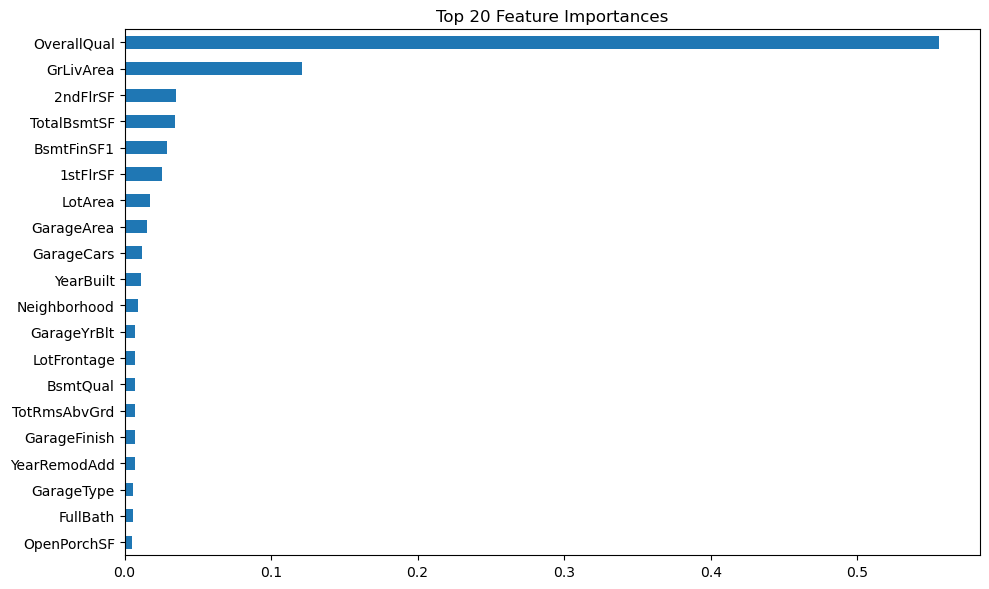

In [9]:
# Feature Importance Plots
import matplotlib.pyplot as plt

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(20).plot(kind='barh', figsize=(10, 6))
plt.title("Top 20 Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [44]:
# !pip install xgboost


/Users/jakefitzgerald/anaconda3/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [10]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Assume X and y are already prepped like before
X = df.drop(columns=["SalePrice"])
y = df["SalePrice"]

# Label encode categoricals (same as before)
from sklearn.preprocessing import LabelEncoder
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Handle missing values
X = X.fillna(0)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build model
model_xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model_xgb.fit(X_train, y_train)

# Predict and evaluate manually
y_pred = model_xgb.predict(X_test)
rmse = ((y_test - y_pred) ** 2).mean() ** 0.5
print(f"XGBoost RMSE: {rmse:.2f}")

XGBoost RMSE: 25429.53


Step =  0
thetaold =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
L(thetaold) =  38802170000.0
gradL(thetaold) =  [-362467.88     16118.97     15969.09    -26741.79    -58229.94
   -8450.626    -5505.337    40600.895    -4939.5186   -2509.7715
   20498.82    -14717.642   -31980.96    -10701.7     -10004.667
   21166.637   -32650.686  -123049.516     7000.543   -69857.09
  -75890.2     -47601.668   -10965.063   -16149.077   -19128.13
   -6208.735   -68230.836    98572.25    -10843.922   -59192.83
   83253.19     -8855.058    34637.906    13098.489   -57705.656
  -18029.096     3286.4316  -37766.547   -96823.72     12308.162
   53868.164   -30685.113   -33585.07    -99614.164   -53905.86
    -731.646  -118133.12    -26599.004     3338.9058  -87948.4
  -38251.105   -4

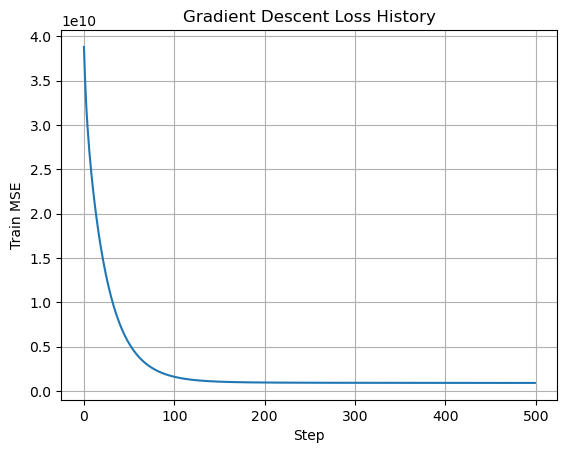

In [13]:
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Prep data
df = us_data.drop(columns=['Id']).copy()

# Separate features & target
y_np = df['SalePrice'].values
X_df = df.drop(columns=['SalePrice'])

# Identify categorical vs. numeric
cat_cols = X_df.select_dtypes(include=['object']).columns
num_cols = X_df.select_dtypes(exclude=['object']).columns

# Fill missing values: categoricals adopt 'MISSING', numerics adopt 0
X_df[cat_cols] = X_df[cat_cols].fillna('MISSING').astype(str)
X_df[num_cols] = X_df[num_cols].fillna(0)

# Label encode categoricals
for c in cat_cols:
    X_df[c] = LabelEncoder().fit_transform(X_df[c])

# Scale features
X_scaled = StandardScaler().fit_transform(X_df)

# Add intercept column
X_b_np = np.c_[np.ones((X_scaled.shape[0], 1)), X_scaled]

# Train/val/test split (60/20/20)
X_temp, X_test_np, y_temp, y_test_np = train_test_split(X_b_np, y_np, test_size=0.20, random_state=42)
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Convert to JAX arrays via jnp
X_train = jnp.array(X_train_np)
y_train = jnp.array(y_train_np)
X_val = jnp.array(X_val_np)
y_val = jnp.array(y_val_np)
X_test = jnp.array(X_test_np)
y_test = jnp.array(y_test_np)

# Define loss function L(θ) = MSE on the training set
def L(theta):
    preds = X_train.dot(theta) # utilizes dot - multiplies each row of x train by corresponding weights in theta
    return jnp.mean((preds - y_train)**2) # takes the mean after subtracting the true sales price from our prediction & squaring it

# Get gradient function via JAX autodiff
def gradL(theta):
    return jax.grad(L)(theta)

# Define gradient descent
def gradient_descent(theta, alpha, num_steps, tolerance=1e-4):
    thetaold = theta
    Losshistory = []
    theta_history = []

    for i in range(num_steps):
        # compute the loss value
        Lossvalue = L(thetaold)
        # append the loss value to the history
        Losshistory.append(Lossvalue)
        # compute the gradient
        gradvalue = gradL(thetaold)

        # update the parameters
        thetanew = thetaold - alpha * gradvalue
        theta_history.append(thetanew)

        # print the current step, thetaold, Lossvalue, and gradvalue
        print("Step = ", i)
        print("thetaold = ", thetaold)
        print("L(thetaold) = ", Lossvalue)
        print("gradL(thetaold) = ", gradvalue)
        print("")

        # check convergence
        if jnp.max(jnp.abs(thetanew - thetaold)) < tolerance:
            print("Converged")
            break

        thetaold = thetanew
        if i == num_steps - 1:
            print("Max iterations reached without convergence!")

    return thetanew, Losshistory, theta_history

# Run gradient descent
theta0 = jnp.zeros(X_train.shape[1])   # initialize θ to zeros
alpha = 0.01 # learning rate (determines step size)
num_steps = 500 # max number of epochs

theta_hat, Losshistory, theta_history = gradient_descent(theta0, alpha, num_steps)
print("Learned θ:", theta_hat) # theta hat stores coefficients minimizing MSE

# Evaluate on test set
y_pred_test = X_test.dot(theta_hat) # make predictions on test features
test_rmse = jnp.sqrt(jnp.mean((y_test - y_pred_test)**2))
print(f"\nFinal Test RMSE: {test_rmse:.2f}") # prints final test rmse

# Evaluate on validation set
y_pred_val = X_val.dot(theta_hat)
val_rmse   = jnp.sqrt(jnp.mean((y_val - y_pred_val)**2))
print(f"\nFinal Validation RMSE: {val_rmse:.2f}")

# Plot loss history
plt.plot(Losshistory)
plt.xlabel("Step")
plt.ylabel("Train MSE")
plt.title("Gradient Descent Loss History")
plt.grid(True)
plt.show()



Running Ridge GD with lambda = 0.01
thetaold = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
L_ridge(thetaold) = 38802170000.0
gradL_ridge(thetaold) = [-362467.88     16118.97     15969.09    -26741.79    -58229.94
   -8450.626    -5505.337    40600.895    -4939.5186   -2509.7715
   20498.82    -14717.642   -31980.96    -10701.7     -10004.667
   21166.637   -32650.686  -123049.516     7000.543   -69857.09
  -75890.2     -47601.668   -10965.063   -16149.077   -19128.13
   -6208.735   -68230.836    98572.25    -10843.922   -59192.83
   83253.19     -8855.058    34637.906    13098.489   -57705.656
  -18029.096     3286.4316  -37766.547   -96823.72     12308.162
   53868.164   -30685.113   -33585.07    -99614.164   -53905.86
    -731.646  -118133.12    -26599.004     3

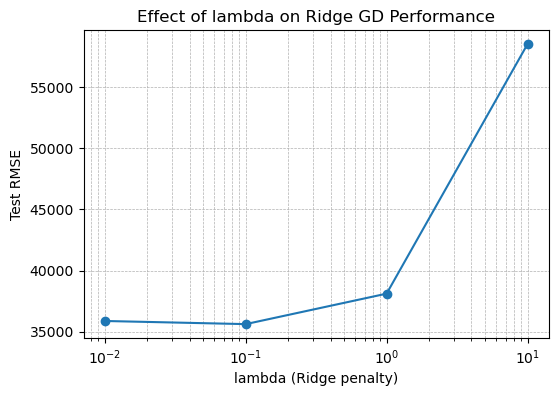

In [16]:
import pandas as pd

# Prep data - remove Id from data
df = us_data.drop(columns=['Id']).copy()

# Separate features & target
y_np = df['SalePrice'].values
X_df = df.drop(columns=['SalePrice'])

# Identify categorical vs. numeric
cat_cols = X_df.select_dtypes(include=['object']).columns
num_cols = X_df.select_dtypes(exclude=['object']).columns

# Fill missing values: categoricals adopt 'MISSING', numerics adopt 0
X_df[cat_cols] = X_df[cat_cols].fillna('MISSING').astype(str)
X_df[num_cols] = X_df[num_cols].fillna(0)

# Label encode categoricals
for c in cat_cols:
    X_df[c] = LabelEncoder().fit_transform(X_df[c])

# Scale features
X_scaled = StandardScaler().fit_transform(X_df)

# Add intercept column
X_b_np = np.c_[np.ones((X_scaled.shape[0], 1)), X_scaled]

# Train/val/test split (60/20/20)
X_temp, X_test_np, y_temp, y_test_np = train_test_split(X_b_np, y_np, test_size=0.20, random_state=42) # assigns 80% of data to X temp, leaving 20% for hold-out set
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42) # pulls 25% of the X temp, giving us (25% of 80) 20% for validation

# Convert to JAX arrays via jnp
X_train = jnp.array(X_train_np)
y_train = jnp.array(y_train_np)
X_val = jnp.array(X_val_np)
y_val = jnp.array(y_val_np)
X_test = jnp.array(X_test_np)
y_test = jnp.array(y_test_np)

# Ridge Regression setup

def L_ridge(theta):
    preds = X_train.dot(theta)
    mse = jnp.mean((preds - y_train)**2)
    # do not penalize bias term theta[0]:
    w = theta[1:]
    penalty = lambda_ * jnp.sum(w**2)
    return mse + penalty

# Get gradient function via JAX autodiff
def gradL_ridge(theta):
    return jax.grad(L_ridge)(theta)

# Define gradient descent
def gradient_descent_ridge(theta, alpha, num_steps, tolerance=1e-4):
    thetaold = theta
    losshistory = []
    theta_history = []

    for i in range(num_steps):
        # compute loss + gradient
        lossval = L_ridge(thetaold)
        # append the loss value to the history
        losshistory.append(lossval)
        # compute the gradient
        gradval = gradL_ridge(thetaold)

        # update the parameters
        thetanew = thetaold - alpha * gradval
        theta_history.append(thetanew)

        # print the current step, thetaold, Lossvalue, and gradvalue
        #print("Step =", i)
        print("thetaold =", thetaold)
        print("L_ridge(thetaold) =", lossval)
        print("gradL_ridge(thetaold) =", gradval)
        print()

        # check convergence
        if jnp.max(jnp.abs(thetanew - thetaold)) < tolerance:
            print("Converged")
            break

        thetaold = thetanew
        if i == num_steps - 1:
            print("Max iterations reached without convergence!")

    return thetanew, losshistory, theta_history

# Run ridge gradient descent, evaluate, and plot

theta0 = jnp.zeros(X_train.shape[1])  # initialize θ = 0
alpha = 0.01 # learning rate (determines step size)
num_steps = 500 # max number of epochs

# Define the grid of lambda’s we want to test, offering variability in our penalty constraint.
lambda_list = [0.01, 0.1, 1.0, 10.0]

# Prepare lists to store the resulting RMSEs of various lambda values
rmse_list = []
val_rmse_list = []

# Loop over each lambda, re‑run GD, evaluate, and append RMSE
for lambda_ in lambda_list:
    print(f"\nRunning Ridge GD with lambda = {lambda_}")
    theta_ridge, loss_ridge_hist, _ = gradient_descent_ridge(
        theta0, alpha, num_steps
    )
    # validation set RMSE
    y_pred_val = X_val.dot(theta_ridge)
    val_rmse   = float(jnp.sqrt(jnp.mean((y_val - y_pred_val)**2)))
    print(f"Val   RMSE (lambda={lambda_}): {val_rmse:.2f}")
    val_rmse_list.append(val_rmse)

    # test set RMSE
    y_pred_test = X_test.dot(theta_ridge)
    test_rmse   = float(jnp.sqrt(jnp.mean((y_test - y_pred_test)**2)))
    print(f"Test RMSE (lambda={lambda_}): {test_rmse:.2f}")
    rmse_list.append(test_rmse)

# create a table to view the rmse output for each lambda value
results = pd.DataFrame({ 
    'lambda': lambda_list,
    'val_RMSE': val_rmse_list,
    'test_RMSE': rmse_list
    })
print(results)

# Plot lambda vs. RMSE
plt.figure(figsize=(6,4))
plt.semilogx(lambda_list, rmse_list, marker='o', linestyle='-')
plt.xlabel("lambda (Ridge penalty)")
plt.ylabel("Test RMSE")
plt.title("Effect of lambda on Ridge GD Performance")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()
